In [29]:
pwd


'/Users/david'

In [ ]:
#pip install yfinance

In [1]:
import yfinance as yf
import pandas as pd
from functools import reduce

In [2]:
def getYData(tickerSymbol,period='1d',start='2010-1-1',end='2020-3-13'):
    tickerData = yf.Ticker(tickerSymbol)
    tickerDf = tickerData.history(period='1d', start='2010-1-1', end='2020-3-13')
    return(tickerDf['Close'])

In [3]:
tickerSymbols = ['AMZN','GOOG','ZM','EPD','^GSPC','^IRX']

In [4]:
raw = []
for i in tickerSymbols:
    raw.append(getYData(i))

In [5]:
P = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],how='outer'), raw)

In [6]:
P.columns = tickerSymbols

In [7]:
r_rf = P['^IRX']/252

In [8]:
del P['^IRX']

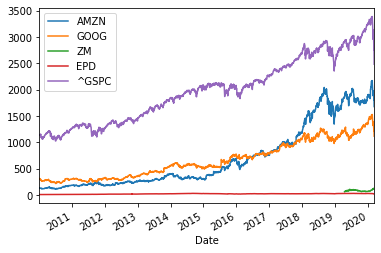

In [12]:
P.plot(kind='line')

In [10]:
R = P.pct_change(1)

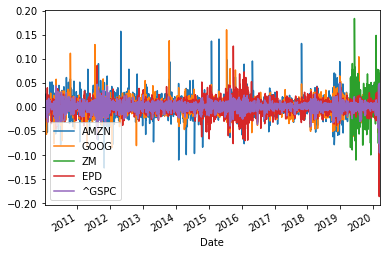

In [11]:
R.plot(kind='line')

In [13]:
r_mkt = R['^GSPC']

In [14]:
import statsmodels.api as sm


In [15]:
tBreak = '2020-02-14'

In [17]:
def PrepareData(r,r_mkt,r_rf,tBreak = None):
    raw = [r,r_mkt,r_rf]
    R = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],how='outer'), raw)
    R.columns = ['r','r_mkt','r_rf']
    R = R.dropna(axis=0, how='any')
    if tBreak != None:
        R1 = R.loc[R.index <= tBreak]
        R2 = R.loc[R.index > tBreak]
        return([R1,R2])
    else:
        return(R)

In [18]:
def getModel(r,r_mkt,r_rf,tBreak = None):
    R = PrepareData(r,r_mkt,r_rf)
    
    r = R['r']
    r_mkt = R['r_mkt']
    r_rf = R['r_rf']
    
    y = r - r_rf
    x = r_mkt - r_rf
    fit = sm.OLS(y,x).fit()
    return(fit)

In [19]:
def getBeta(r,r_mkt,r_rf):  
    fit = getModel(r,r_mkt,r_rf)
    out = pd.read_html(fit.summary().tables[1].as_html(),header=0,index_col=0)
    beta = out[0]['coef'][0]
    return(beta)

In [21]:
def FitN4cast(r,r_mkt,r_rf,tBreak):
    R1,R2 = PrepareData(r,r_mkt,r_rf,tBreak)
    b = getBeta(R1['r'],r_mkt,r_rf)
    rhat = b*R2['r_mkt']
    r = R2['r']
    return([rhat,r])

In [23]:
r = R['GOOG']
rhat,r = FitN4cast(r,r_mkt,r_rf,tBreak)

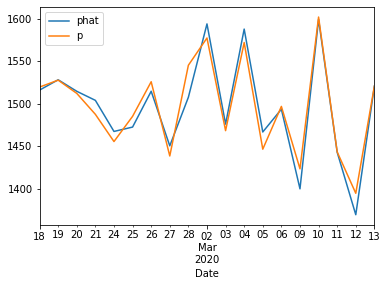

In [26]:
p_t = P.loc[P.index == tBreak].GOOG[0]
phat = p_t * (1+rhat)
p = p_t * (1+r)
d = {'phat': phat, 'p': p}
df = pd.DataFrame(data=d)
df.plot(kind='line')